In [1]:
%matplotlib inline
import torch
import torchvision
import pandas as pd
import numpy as np
from torch import nn
from d2l import torch as d2l

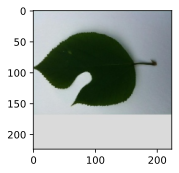

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../data/classify-leaves/images/23.jpg')
d2l.plt.imshow(img);

In [3]:
train_data = pd.read_csv('../data/classify-leaves/train.csv')

In [4]:
className = train_data['label'].value_counts()
className

maclura_pomifera            353
ulmus_rubra                 235
prunus_virginiana           223
acer_rubrum                 217
broussonettia_papyrifera    214
                           ... 
ulmus_procera                58
ailanthus_altissima          58
crataegus_crus-galli         54
evodia_daniellii             53
juniperus_virginiana         51
Name: label, Length: 176, dtype: int64

In [18]:
lit  = list(range(0,train_data['label'].nunique()))
classValue = pd.Series(lit, index= className.index )
classValue

maclura_pomifera              0
ulmus_rubra                   1
prunus_virginiana             2
acer_rubrum                   3
broussonettia_papyrifera      4
                           ... 
ulmus_procera               171
ailanthus_altissima         172
crataegus_crus-galli        173
evodia_daniellii            174
juniperus_virginiana        175
Length: 176, dtype: int64

In [5]:
for i in range(0,train_data['label'].nunique()):
    className[i] = i

className

maclura_pomifera              0
ulmus_rubra                   1
prunus_virginiana             2
acer_rubrum                   3
broussonettia_papyrifera      4
                           ... 
ulmus_procera               171
ailanthus_altissima         172
crataegus_crus-galli        173
evodia_daniellii            174
juniperus_virginiana        175
Name: label, Length: 176, dtype: int64

In [6]:
train_data['labelValue'] = classValue[train_data['label'].values].values
train_data

,image,label,LabelValue
0,images/0.jpg,maclura_pomifera,0
1,images/1.jpg,maclura_pomifera,0
2,images/2.jpg,maclura_pomifera,0
3,images/3.jpg,maclura_pomifera,0
4,images/4.jpg,maclura_pomifera,0
...,...,...,...
18348,images/18348.jpg,aesculus_glabra,85
18349,images/18349.jpg,liquidambar_styraciflua,73
18350,images/18350.jpg,cedrus_libani,65
18351,images/18351.jpg,prunus_pensylvanica,120


In [7]:
lst = [1,3,5,6,10,23]
s = pd.Series(lst,index=["A","B","C","D","E","F"]) # 通过index设置显式索引
s

A     1
B     3
C     5
D     6
E    10
F    23
dtype: int64

In [17]:
lsttt = [11,13,15,16,10,23]
lll = list(range(0,6))
ss = pd.Series(lll, index= s.index )
ss

A    0
B    1
C    2
D    3
E    4
F    5
dtype: int64